<a href="https://colab.research.google.com/github/quddaz/Machine_Learing/blob/main/5-2%20%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D%2C%EA%B7%B8%EB%A6%AC%EB%93%9C%EC%84%9C%EC%B9%98%2C%20%EB%9E%9C%EB%8D%A4%EC%84%9C%EC%B9%98%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차 검증과 그리드 서치



> **검증 세트**

+ 테스트 세트를 사용하지 않고 훈련 세트를 나누는 것
+ 실제로 많이 사용하는 방법

우리가 평상시에 했던 방법은 훈련세트와 검증 세트를 나눠서 사용했다.



> **검증 세트 만들기**

+ 훈련 세트 : 80%, 테스트 세트: 20%
+ 훈련 세트에서 모델을 훈련하고 검증 세트로 모델을 평가
+ 테스트하고 싶은 매개변수를 바꿔가며 가장 좋은 모델을 고른다.
+ 훈련 세트와 검증 세트를 합쳐 전체 훈련 데이터에서 모델을 다시 훈련
+ 마지막으로 테스트 세트에서 최종 점수 평가
+ 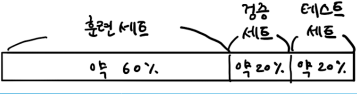





In [2]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [3]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [4]:

sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [5]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


여기서 3은 feature이다

In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


일반적으로 교차검증은 여러번 반복해야 정확해진다고 한다.
+ 검증 세트를 만들어 사용하니 훈련 세트가 줄어들게 됨
+ 검증 세트를 조금 대어 놓으면 점수가 불안정함
+ 검증 세트를 떼어 내어 평가 과정을 여러 번 반복
+ 이 점수들을 평균하여 최종 검증 점수를 얻는다.

일반적인 방법은 5-폴드나 10-폴드를 사용한다.(80~90% 훈련 가능)

## 교차 검증



> 사이킷 런의 cross_validate() 교차 검증 함수



In [7]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.03173614, 0.0108645 , 0.01137543, 0.01121211, 0.01518536]), 'score_time': array([0.00226951, 0.00248098, 0.00206065, 0.00204849, 0.00209594]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


각각 훈련 시간, 검증 시간, 최종 점수로 5개의 결과가 나와 5-폴드 교차 검증이다.



In [9]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


해당 값이 최종 점수의 평균이다.

## 분할기를 사용한 교차 검증



> **분할기란?**

+ train_test-splict() 함수를 사용하여 자료를 섞을 필요가 없었음
+ cross_validate() 함수는 자료를 섞어줘야 한다.
+ StratifiedKFold() 함수는 타깃 클래스를 골구로 나눠 준다.



In [10]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


10-폴드 교차 검증을 해보자

In [11]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝

결정 트리의 단점은 그대로 두면 너무 과대적합되는 것에 있다. 우리는 하이퍼파라미터 튜닝을 통해 이것을 해결해보자



> **하이퍼파라미터 튜닝하는 방법**

+ 처음에는 라이브러리의 기본값을 사용하여 훈련
+ 검증 세트나 교차 검증을 통해서 매개변수를 조금씩 바꿔서 훈련
+ 모델마다 1~6개의 매개변수를 바꿔가면서 모델 훈련하여 교차 검증을 수행



> **하이퍼파라미터 튜닝의 문제점**

+ 하나의 매개변수를 고정하고 다른 매개변수를 바꾸면 될 수도 잇지만 같이 움직이는 매개변수들도 존재함
+ 예를들면 max_depth와 min_samples_split은 같이 움직임
+ 매개변수가 많으면 대단히 어렵다




> **하이퍼파라미터 튜닝의 해결방법**

+ GridSearchCV 클래스를 사용
+ 하이퍼파라미터 탐색과 교차 검증을 한번에 수행






In [12]:
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [13]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)


dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


cv가 5이기 때문에 25번의 교차 검증이 일어난다.
+ 25개의 모델 중 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델을 훈련한다.

In [14]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [15]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


각 매개변수에서 수행한 교차 검증의 평균 점수는 각각 cv_results_의 속성에 mean_test_score에 저장된다.

## 그리드 서치

넘파이 argmax() 함수를 사용하여 가장 큰 값의 인덱스를 추출하자


> 탐색 순서

+ 탐색할 매개변수를 지정
+ 훈련 세트에서 그리드 서치를 수행하는 최상의 평균 검증 점수가 나오는 매개변수 조합을 찾는다. 각 그리드 서치 객체에 저장
+ 그리드 서치는 최상의 매개변수에서 전체 훈련 세트를 사용해 최종 모델을 훈련한다.



In [17]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [18]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [19]:

gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [20]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [21]:

print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731




> 그리드 서치의 장점

+ 최적의 매개변수 값을 찾아준다.



> 그리드 서치의 단점

+ 너무 무겁다. 너무 많은 시간이 걸림





# 랜덤 서치(확률 분포 선택)

말 그대로 랜덤으로 서치한다. 1~10이 있을 때 랜덤으로 1개를 골라 서치를 한다.

그렇기에 1번만하는 것이 아닌 반복적으로 수행한다.

+ 매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어렵다
+ 또한 너무 많은 매개변수 조건이 있어 그리드 서치의 수행시간이 매우 크다.
+ 매개변수 값의 목록을 전달하는 것이 아니라 매개변수를 샘플링할 수 잇는 확률 분포 객체를 전달하는 것이 랜덤 서치이다.

그리드 서치는 너무 좋은 값을 찾지만 랜덤 서치는 여러번 실행 한 것 중에서 제일 나은 값을 찾는다.
+ 즉 꼭 최적해가 아니지만 좋은 값을 찾는다.

In [22]:

from scipy.stats import uniform, randint

rgen = randint(0, 10)
rgen.rvs(10)

array([3, 5, 0, 4, 5, 2, 3, 6, 7, 3])

In [23]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([109, 106,  87, 104,  80, 101, 101, 105, 108,  99]))

In [24]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.4137113 , 0.94758878, 0.08338652, 0.60558323, 0.17490798,
       0.91312291, 0.25876538, 0.71562915, 0.59038042, 0.31232935])

In [25]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [26]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b23c3a7b910>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b23c3ad9d80>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b23c3a7af80>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b23c3ad9660>},
                   random_state=42)

이 함수에서 100번을 돌리고 있다.(n_iter=100)

In [27]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [28]:

print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884
